<a href="https://colab.research.google.com/github/w4bo/handsOnDataPipelines/blob/main/materials/02-MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scikit-learn, Machine Learning in Python
- Simple and efficient tools for predictive data analysis
- Accessible to everybody, and reusable in various contexts
- Built on NumPy, SciPy, and matplotlib
- Open source, commercially usable - BSD license


Check also: 
- https://scikit-learn.org/stable/index.html
- https://scikit-learn.org/stable/modules/tree.html

In [7]:
!pip install paretoset 

from paretoset import paretoset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
np.random.seed(42)  # why are we fixing the seed?

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Solution of the previous `Hands on`

In [8]:
def preprocess(normalize=True):
    df = pd.read_csv("http://big.csr.unibo.it/projects/nosql-datasets/2022-bbs-dsaa-housing.csv", delimiter=",")
    
    num_df = df.drop(columns=["ocean_proximity", "median_house_value"])

    # Filling in (i.e., impute) missing values with the median value 
    num_df["total_bedrooms"] = num_df["total_bedrooms"].fillna(num_df["total_bedrooms"].median())

    # Add a new column: population_per_household = population / households
    num_df["population_per_household"] = num_df["population"] / num_df["households"]

    # Add a new column: rooms_per_household = total_rooms / households
    num_df["rooms_per_household"] = num_df["total_rooms"] / num_df["households"]

    # Add a new column: bedrooms_per_room = total_bedrooms / total_rooms
    num_df["bedrooms_per_room"] = num_df["total_bedrooms"] / num_df["total_rooms"]

    if normalize:
        # Apply standardization to all the numeric columns
        num_df = (num_df - num_df.mean()) / num_df.std()

    # One hot encode `ocean_proximity` since it is a categorical attribute 
    cat_df = pd.get_dummies(df["ocean_proximity"], prefix='ocean_proximity')

    # Join all the dataframes
    return pd.concat([num_df, cat_df, df[["median_house_value"]]], axis=1) # do not change this line

df = preprocess()

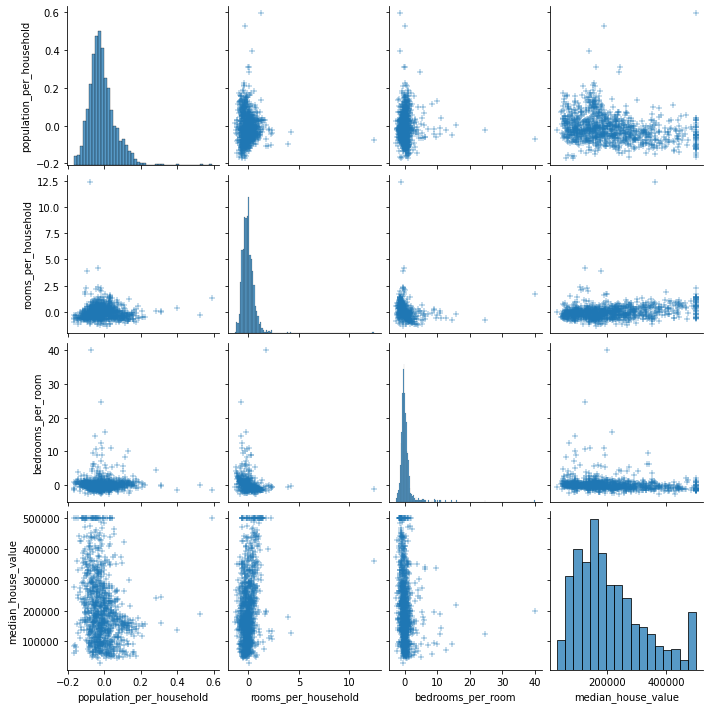

In [9]:
tmp = df[["population_per_household", "rooms_per_household", "bedrooms_per_room", "median_house_value"]]
sns.pairplot(tmp.sample(n=1000, random_state=42), markers='+')
plt.show()

Before delving into machine learning, which are the houses the represent a good tradeof between cost and number of rooms?

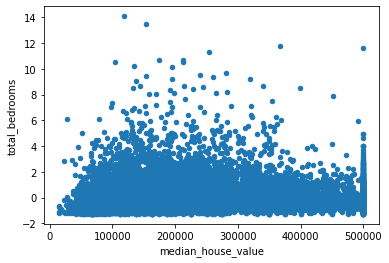

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1)
df.plot.scatter(x='median_house_value', y='total_bedrooms', ax=ax)

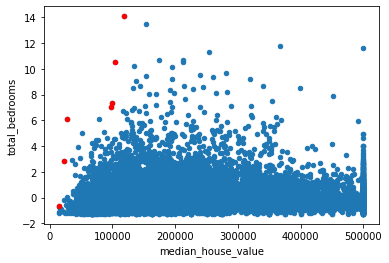

In [11]:
mask = paretoset(df[["median_house_value", "total_bedrooms"]], sense=["min", "max"])
df[mask].plot.scatter(x='median_house_value', y='total_bedrooms', ax=ax, c='red')
fig

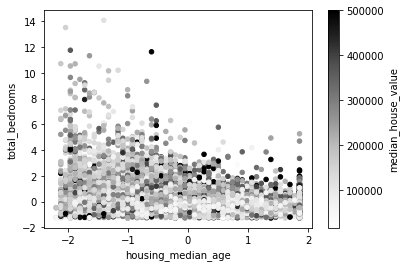

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)
df.plot.scatter(x="housing_median_age", y="total_bedrooms", c="median_house_value", ax=ax)

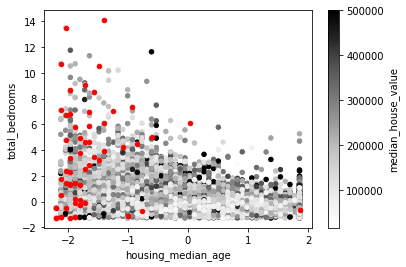

In [13]:
mask = paretoset(df[["housing_median_age", "total_bedrooms", "median_house_value"]], sense=["min", "max", "min"])
df[mask].plot.scatter(x="housing_median_age", y="total_bedrooms", ax=ax, c='red')
fig

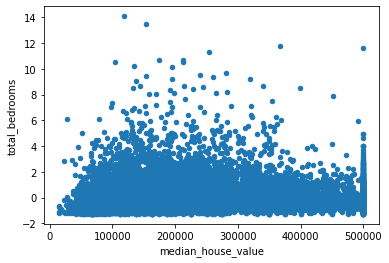

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1)
df.plot.scatter(x='median_house_value', y='total_bedrooms', ax=ax)

For a supervised learning problem we need:
- input data along with labels
- split data between test and training set. How?

In [15]:
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) # get a list of random numbers
    test_set_size = int(len(data) * test_ratio) # define the size of test dataset
    test_indices = shuffled_indices[:test_set_size] # the test dataset includes some indexes 
    train_indices = shuffled_indices[test_set_size:] # the train dataset includes the others (no overlapping)
    return data.iloc[train_indices], data.iloc[test_indices] # return the two dataframes

df_train, df_test = split_train_test(df, 0.2) # get the train and test dataframes

X_train = df_train.drop(columns=["median_house_value"]).to_numpy() # get the train feature matrix
X_test  = df_test.drop(columns=["median_house_value"]).to_numpy() # get the test feature matrix
y_train = df_train["median_house_value"].to_numpy() # get the train label array
y_test  = df_test["median_house_value"].to_numpy() # get the test label array

In [16]:
from sklearn.model_selection import train_test_split
y = df["median_house_value"] # labels
X = df.drop(columns=["median_house_value"]) # input data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,population_per_household,rooms_per_household,bedrooms_per_room,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
5088,0.643716,-0.773361,-0.765917,-0.803424,-0.533722,-0.617660,-0.582062,-1.521075,-0.043300,-0.905868,2.156065,1,0,0,0,0
17096,-1.327803,0.855889,0.346470,0.003317,-0.173677,-0.362464,-0.189731,0.185559,-0.066782,0.307455,-0.586009,0,0,0,0,1
5617,0.653698,-0.862314,1.061575,-0.675538,-0.650558,-0.336856,-0.676222,-0.169422,0.121441,-0.245505,0.205376,1,0,0,0,0
20060,0.154579,0.111491,-0.368636,-0.479353,-0.350123,0.230050,-0.333586,-1.170516,0.140728,-0.466744,0.482602,0,1,0,0,0
895,-1.193041,0.893343,-1.163197,1.132297,1.597935,1.159000,1.591454,0.063284,-0.057725,-0.331705,0.346285,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.803433,-0.866996,0.505382,-0.598530,-0.800776,-0.677706,-0.738995,1.315560,-0.003697,0.282936,-0.960430,1,0,0,0,0
11964,1.067966,-0.754634,0.346470,0.205461,0.079070,0.289213,-0.132189,-0.431973,0.080259,0.581850,-0.443985,0,1,0,0,0
5390,0.593804,-0.749952,0.584838,-0.245123,0.076685,0.291863,0.071824,-0.492820,0.025170,-0.582935,0.874037,1,0,0,0,0
860,-1.193041,0.912070,-1.083741,0.430524,0.143449,0.310406,0.155521,0.973001,0.010421,0.390575,-0.717278,1,0,0,0,0


In [18]:
y_train

5088     121400.0
17096    363700.0
5617     205600.0
20060     47600.0
895      236000.0
           ...   
11284    229200.0
11964     97800.0
5390     222100.0
860      283500.0
15795    325000.0
Name: median_house_value, Length: 13828, dtype: float64

Apply linear regression to forecast housing values

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

"LinearRegression fits a linear model with coefficients w = (w1, ..., wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation."

70532.34602926503


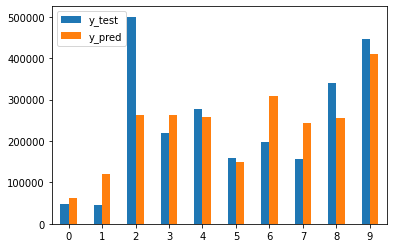

In [19]:
from sklearn.linear_model import LinearRegression # import the model

lin_reg = LinearRegression() # initialize the model (i.e., the estimator)
lin_reg.fit(X_train, y_train) # train it
housing_predictions = lin_reg.predict(X_test) # predict the cost of houses in the test set

lin_mse = mean_squared_error(y_test, housing_predictions) # check the error
lin_rmse = np.sqrt(lin_mse) # apply the squared root of the error
print(lin_rmse) # print it

# visualize some predictions
df = pd.DataFrame({'y_test': y_test[:10].to_numpy(), 'y_pred': housing_predictions[:10]}, index=[x for x in range(10)])
df.plot.bar(rot=0)

This is better than nothing, but clearly not a great score: most districts’ `median_housing_values` range between 120K USD and  265K USD, so a typical prediction error of ~70K USD is not very satisfying. This is an example of a model underfitting the training
data.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

"A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree."

50155.05753085368


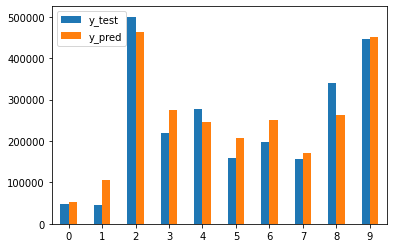

In [20]:
from sklearn.ensemble import RandomForestRegressor # import the model

def run_forest(n_estimators, max_features):
    # initialize the model (i.e., the estimator)
    forest_reg = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, random_state=42)
    forest_reg.fit(X_train, y_train) # train it
    housing_predictions = forest_reg.predict(X_test) # predict the cost of houses in the test set
    
    forest_rmse = mean_squared_error(y_test, housing_predictions, squared=True) # check the error
    forest_rmse = np.sqrt(forest_rmse) # apply the squared root of the error
    print(forest_rmse)
    
    df = pd.DataFrame({'y_test': y_test[:10].to_numpy(), 'y_pred': housing_predictions[:10]}, index=[x for x in range(10)])
    df.plot.bar(rot=0)
    return forest_reg

forest_reg = run_forest(100, "auto")

Look at parameters used by our current forest

In [21]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

"The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings. In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter."

In [22]:
from sklearn.model_selection import RandomizedSearchCV 

n_estimators = [50, 100, 150] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
# auto -> n_features
# sqrt -> max_features=sqrt(n_features)
random_grid = {'n_estimators': n_estimators, 'max_features': max_features}

# Fit the random search model
rf_random = RandomizedSearchCV(estimator = forest_reg, param_distributions = random_grid, cv = 3, verbose=2, random_state=42)
rf_random.fit(X_train, y_train)
rf_random.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .................max_features=auto, n_estimators=50; total time=   4.5s
[CV] END .................max_features=auto, n_estimators=50; total time=   4.3s
[CV] END .................max_features=auto, n_estimators=50; total time=   4.3s
[CV] END ................max_features=auto, n_estimators=100; total time=   8.8s
[CV] END ................max_features=auto, n_estimators=100; total time=   9.5s
[CV] END ................max_features=auto, n_estimators=100; total time=   8.7s
[CV] END ................max_features=auto, n_estimators=150; total time=  13.3s
[CV] END ................max_features=auto, n_estimators=150; total time=  14.0s
[CV] END ................max_features=auto, n_estimators=150; total time=  13.0s
[CV] END .................max_features=sqrt, n_estimators=50; total time=   1.8s
[CV] END .................max_features=sqrt, n_estimators=50; total time=   1.8s
[CV] END .................max_features=sqrt, n_es

{'n_estimators': 150, 'max_features': 'sqrt'}

49157.78470502036


RandomForestRegressor(max_features='sqrt', n_estimators=150, random_state=42)

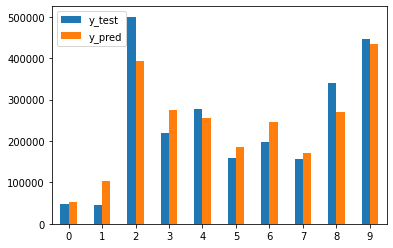

In [23]:
run_forest(150, "sqrt")

#### Dimensionality reduction

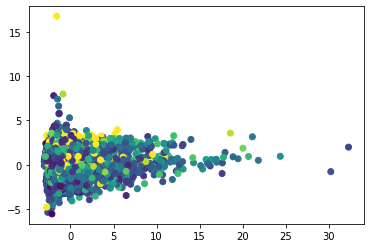

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
result = pca.fit_transform(X_train.values)

# tsne = TSNE(n_components=2)
# result = tsne.fit_transform(X_train)

plt.scatter(
    x=result[:,0], 
    y=result[:,1] , 
    c=y_train, #.apply(lambda x: 0 if x == 'low' else (1 if x == 'medium' else 2)), 
    cmap='viridis'
)

In [25]:
# Dump components relations with features
pd.DataFrame(pca.components_, columns=X_train.columns, index=['PC1', 'PC2'])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,population_per_household,rooms_per_household,bedrooms_per_room,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
PC1,0.067570,-0.064488,-0.218377,0.481213,0.491136,0.475472,0.491947,0.045903,-0.004028,0.007194,-0.011824,0.014685,0.001303,-0.000042,-0.013497,-0.002449
PC2,-0.593374,0.610175,-0.081621,0.108533,0.009148,-0.021333,0.004461,0.222566,0.008746,0.284716,-0.304254,-0.140430,0.082383,-0.000152,0.079831,-0.021631


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


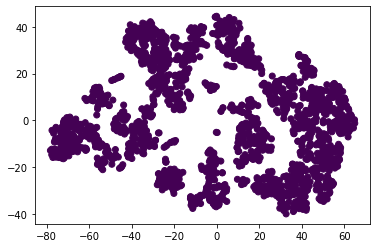

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
result = tsne.fit_transform(X_train.head(2000))

plt.scatter(
    x=result[:,0], 
    y=result[:,1] , 
    c=y_train.head(2000).apply(lambda x: 0 if x == 'low' else (1 if x == 'medium' else 2)), 
    cmap='viridis'
)

#### Classification

- Create classes (low, medium, high) from the target value
- Create and fit a decision tree

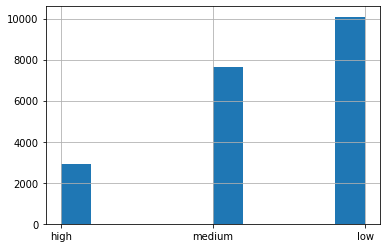

In [27]:
df = preprocess(False) # clean the dataset withtout standardization
bins = ["low", "medium", "high"] # the labels we are gonna use
df["median_house_value"] = pd.cut(df["median_house_value"], 3, labels=bins) # map bins of values into labels
df["median_house_value"].hist() # plot them

For the sake of performance, we are going to use a manually defined set of features

In [28]:
y = df["median_house_value"] # labels
X = df[["latitude", "longitude", "median_income", "population", "households", "total_bedrooms"]] # consider only some features from the train dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # split the dataset

In [29]:
from sklearn.metrics import accuracy_score
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion="entropy", random_state=42) # initialize the model
clf = clf.fit(X_train, y_train) # train it
housing_predictions = clf.predict(X_test) # predict the cost of houses in the test set

accuracy = accuracy_score(y_test, housing_predictions) # check the error
accuracy

0.768349970640047

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, housing_predictions, target_names=bins))

              precision    recall  f1-score   support

         low       0.67      0.70      0.68       958
      medium       0.84      0.84      0.84      3303
        high       0.71      0.70      0.70      2551

    accuracy                           0.77      6812
   macro avg       0.74      0.75      0.74      6812
weighted avg       0.77      0.77      0.77      6812



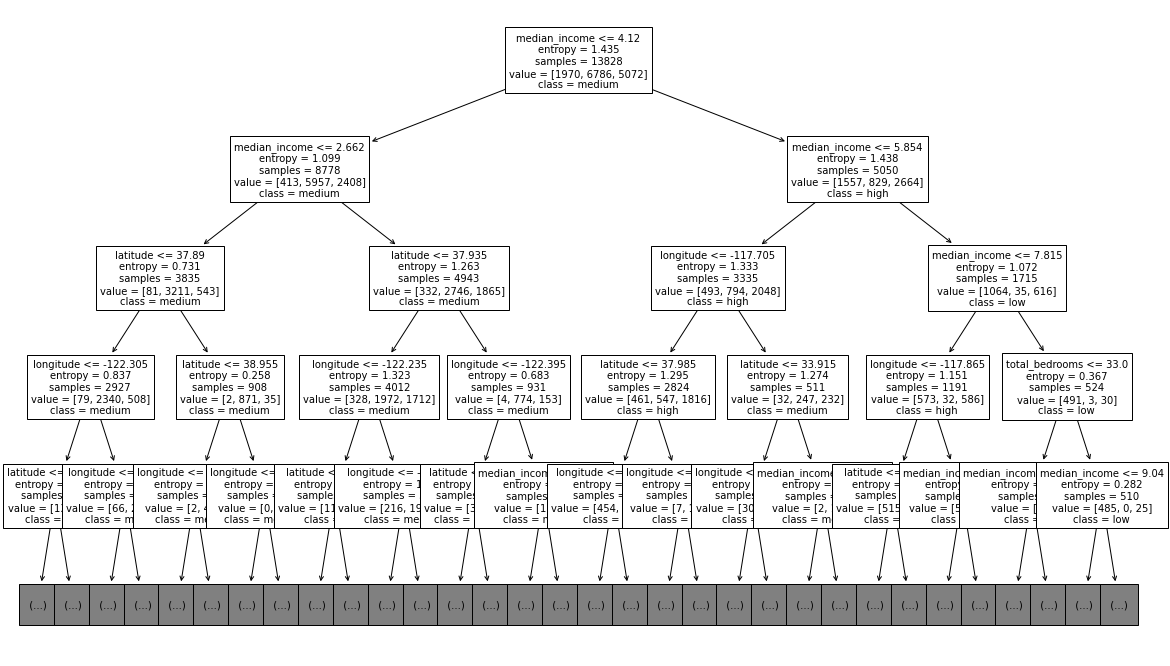

In [31]:
plt.figure(figsize=(20,12))
tree.plot_tree(clf, fontsize=10, feature_names=X_train.columns, class_names=bins, max_depth=4)
plt.show()

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_cls = RandomForestClassifier(criterion="entropy", random_state=42) # initialize the model
forest_cls = forest_cls.fit(X_train, y_train) # train it
housing_predictions = forest_cls.predict(X_test) # predict the cost of houses in the test set

accuracy = accuracy_score(y_test, housing_predictions) # check the error
accuracy

0.8247210804462712

In [33]:
forest_cls.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [34]:
n_estimators = [50, 100, 150]  # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
min_samples_leaf = [1, 5]
max_depth = [2, 5]
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

# Fit the random search model
rf_random = RandomizedSearchCV(estimator=forest_cls, param_distributions=random_grid, cv=3, verbose=2, random_state=42)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=150; total time=   1.0s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=150; total time=   1.0s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, n_estimators=150; total time=   1.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   1.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   1.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   1.3s
[CV] END max_depth=2, max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END max_depth=2, max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END max_depth=2, max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1,

{'n_estimators': 50,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 5}

In [35]:
forest_cls = RandomForestClassifier(criterion="gini", random_state=42, n_estimators=50, max_features="sqrt", min_samples_leaf=1, max_depth=5) 
forest_cls = forest_cls.fit(X_train, y_train) # train it
housing_predictions = forest_cls.predict(X_test) # predict the cost of houses in the test set

accuracy = accuracy_score(y_test, housing_predictions) # check the error
accuracy

0.7298884321785085

In [36]:
forest_cls.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}